#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

In [2]:
RANDOM_STATE = 12345

In [3]:
data = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Ресемплируем данные по одному часу

In [4]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

<AxesSubplot:xlabel='datetime'>

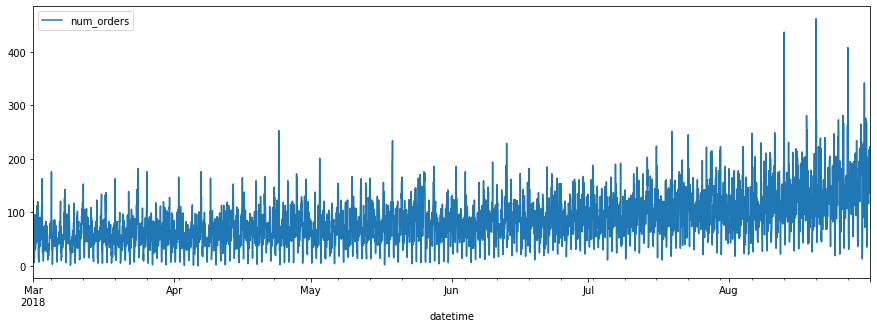

In [5]:
data.plot(figsize=(15,5))

Тренды и сезонность

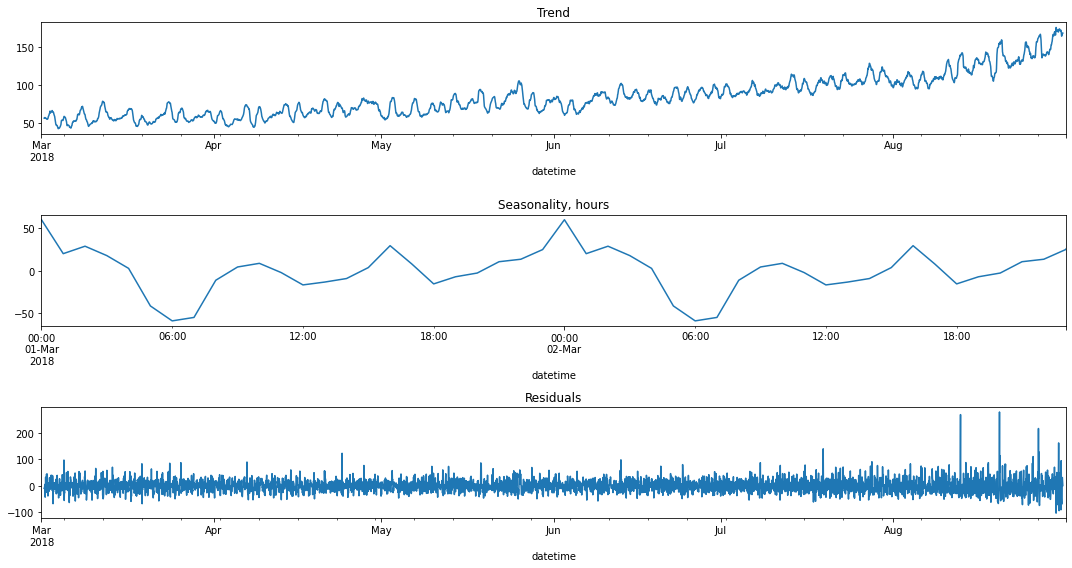

In [6]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(15, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality, hours')
plt.xlim(('2018-03-01 00:00:00','2018-03-02 23:00:00'))
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

По тренду видно, что количество заказов такси растёт во времени. Соответственно растёт и среднее значение временного ряда, а значит ряд не стационарный

Присутствует дневная сезонность, ближе к ночи количество заказов такси растёт, а к утру падает

## Обучение

### Создание признаков

In [7]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [8]:
data = make_features(data, 24, 1)
train,test = train_test_split(data, shuffle = False, random_state = RANDOM_STATE, test_size = 0.1)
train = train.dropna()

features_train = train.drop('num_orders',axis = 1)
features_test = test.drop('num_orders',axis = 1)
target_train = train['num_orders']
target_test = test['num_orders']

In [9]:
splits = TimeSeriesSplit(n_splits=3)

### Линейная регрессия

In [10]:
lr_model = LinearRegression() 
parameters = [{'fit_intercept':[True,False], 
               'normalize':[True,False], 
               'copy_X':[True, False]}]
grid = GridSearchCV(lr_model, parameters, cv = splits, verbose=True,n_jobs=-1, 
                    scoring='neg_mean_squared_error')
grid.fit(features_train, target_train)
print(grid.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
{'copy_X': True, 'fit_intercept': False, 'normalize': True}


In [11]:
lr_model = LinearRegression(copy_X = True, fit_intercept = True, normalize = True)
lr_model.fit(features_train, target_train)
lr_rmse = (cross_val_score(lr_model, features_train, target_train, cv = splits,
                           scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('LinearRegression RMSE =', lr_rmse)

LinearRegression RMSE = 27.70249584363612


### Случайный лес

In [12]:
rfr_model = RandomForestRegressor() 
parameters = [{'n_estimators':[100, 150, 200], 
                'max_depth':[5,10,15],
                'random_state':[RANDOM_STATE]}]
grid = GridSearchCV(rfr_model, parameters, cv = splits, verbose=True,n_jobs=-1, 
                    scoring='neg_mean_squared_error')
grid.fit(features_train, target_train)
print(grid.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
{'max_depth': 15, 'n_estimators': 200, 'random_state': 12345}


In [13]:
rfr_model = RandomForestRegressor(n_estimators = 200, max_depth = 15, 
                                  random_state = RANDOM_STATE)
rfr_model.fit(features_train, target_train)
rfr_rmse = (cross_val_score(rfr_model, features_train, target_train, cv = splits,
                           scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RandomForestRegressor RMSE =', rfr_rmse)

RandomForestRegressor RMSE = 27.802238877155606


### Дерево решений

In [14]:
dtr_model = DecisionTreeRegressor()
parameters = [{'max_depth':[5, 10, 15], 
                'min_samples_split':[10, 20, 30],
                'min_samples_leaf':[10, 30, 50],
                'random_state':[RANDOM_STATE]}]
grid = GridSearchCV(dtr_model, parameters, cv = splits, verbose=True,n_jobs=-1, 
                    scoring='neg_mean_squared_error')
grid.fit(features_train, target_train)
print(grid.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
{'max_depth': 10, 'min_samples_leaf': 30, 'min_samples_split': 10, 'random_state': 12345}


In [15]:
dtr_model = DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 30, min_samples_split = 10,
                                  random_state = RANDOM_STATE)
dtr_model.fit(features_train, target_train)
dtr_rmse = (cross_val_score(dtr_model, features_train, target_train, cv = splits,
                           scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('DecisionTreeRegressor RMSE =', dtr_rmse)

DecisionTreeRegressor RMSE = 30.491925940182565


## Тестирование

In [16]:
lr_predictions_test = lr_model.predict(features_test)
print('RMSE:', mean_squared_error(target_test, lr_predictions_test)**0.5)

RMSE: 45.53149662337182


In [17]:
rfr_predictions_test = rfr_model.predict(features_test)
print('RMSE:',mean_squared_error(target_test, rfr_predictions_test)**0.5)

RMSE: 43.988856416469936


In [18]:
dtr_predictions_test = dtr_model.predict(features_test)
print('RMSE:',mean_squared_error(target_test, dtr_predictions_test)**0.5)

RMSE: 50.626843620815315


Лучше всего на тестовой выборке себя показал случайный лес

Посмотрим на графике насколько точны предсказания

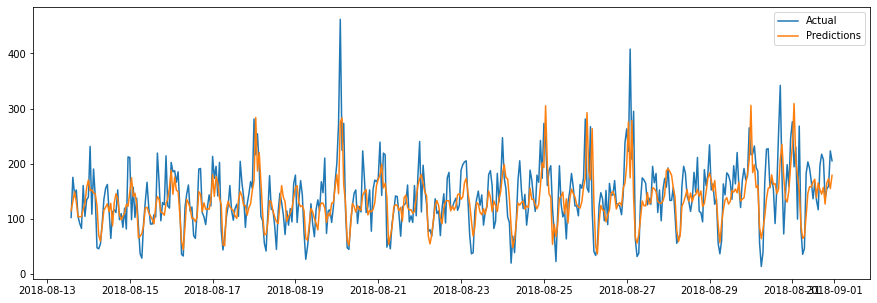

In [19]:
plt.figure(figsize=(15, 5))
plt.plot(features_test.index, target_test, label='Actual')
plt.plot(features_test.index, rfr_predictions_test, label='Predictions')
plt.legend()
plt.show()